In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from rdkit.Chem import Fragments

# First dataset processing

In [2]:

df1 = pd.read_csv("data/cardiotoxity-1.csv")
df1['tr-1'] = pd.read_csv("data/cardiotoxity-1.csv")['Toxicity Value']
df1['tr-5'] = pd.read_csv("data/cardiotoxity-5.csv")['Toxicity Value']
df1['tr-10'] = pd.read_csv("data/cardiotoxity-10.csv")['Toxicity Value']
df1['tr-30'] = pd.read_csv("data/cardiotoxity-30.csv")['Toxicity Value']
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TAID              1547 non-null   object 
 1   Name              441 non-null    object 
 2   IUPAC Name        1291 non-null   object 
 3   PubChem CID       1295 non-null   float64
 4   Canonical SMILES  1547 non-null   object 
 5   InChIKey          1295 non-null   object 
 6   Toxicity Value    1547 non-null   int64  
 7   tr-1              1547 non-null   int64  
 8   tr-5              1547 non-null   int64  
 9   tr-10             1547 non-null   int64  
 10  tr-30             1547 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 133.1+ KB


In [3]:
df1 = df1[['Canonical SMILES', 'tr-1', 'tr-5', 'tr-10', 'tr-30']]
df1 = df1.drop_duplicates(subset=['Canonical SMILES'], keep='last')
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1546
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Canonical SMILES  1545 non-null   object
 1   tr-1              1545 non-null   int64 
 2   tr-5              1545 non-null   int64 
 3   tr-10             1545 non-null   int64 
 4   tr-30             1545 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 72.4+ KB


In [4]:
df1.describe()

,tr-1,tr-5,tr-10,tr-30
count,1545.000000,1545.000000,1545.000000,1545.000000
mean,0.225890,0.461489,0.612945,0.829773
std,0.418302,0.498676,0.487234,0.375953
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000
75%,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


<Axes: >

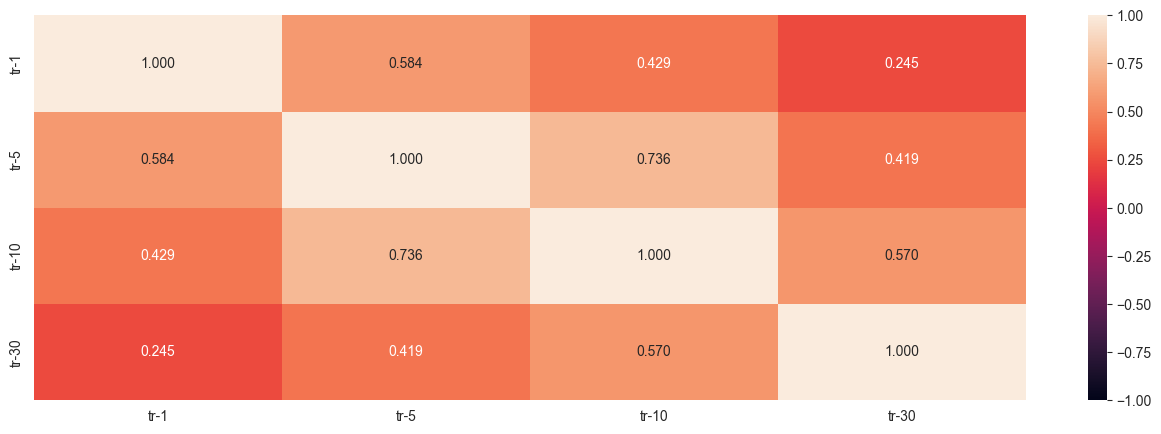

In [5]:
corr = df1.corr(numeric_only=True)
plt.figure(figsize = (16,5))
sns.heatmap(corr, vmax=1, vmin=-1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt=".3f")

In [6]:
df1 = df1[['Canonical SMILES', 'tr-10']]
df1 = df1.rename(columns={"Canonical SMILES": 'SMILES', "tr-10": "bloker"})
df1.head(10)

,SMILES,bloker
0,S=c1nc[nH]c2nc[nH]c12,1
1,[NH3+][C@@H](CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1...,0
2,Nc1nnc(-c2cccc(Cl)c2Cl)c(N)n1,0
3,O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O...,0
4,O=C(c1ccc(OCC[NH+]2CCCCC2)cc1)c1c(-c2ccc(O)cc2...,0
5,Nc1nc2ccc(OC(F)(F)F)cc2s1,0
6,O=C1CCc2cc(OCCCCc3nnnn3C3CCCCC3)ccc2N1,1
7,[NH3+]CC1(CC(=O)[O-])CCCCC1,0
8,NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CC[NH+](CCc2...,1
9,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,1


In [7]:
from rdkit import Chem
df1['molecula'] = df1['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1546
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SMILES    1545 non-null   object
 1   bloker    1545 non-null   int64 
 2   molecula  1545 non-null   object
dtypes: int64(1), object(2)
memory usage: 48.3+ KB


In [8]:
df1.isna().sum()

SMILES      0
bloker      0
molecula    0
dtype: int64

# Second dataset processing

In [9]:
df2 = pd.read_table('data/cardiotoxity-regression.txt', sep='\t')
df2.head()

,SAMPLE_ID,SAMPLE_DATA_ID,PROTOCOL_NAME,SAMPLE_DATA_TYPE,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,...,CAS,PUBCHEM_CID,PUBCHEM_SID,PURITY_RATING,PURITY_RATING_4M,SAMPLE_NAME,SMILES,TOX21_ID,PURITY,Unnamed: 55
0,NCGC00255163-01,243694629,tox21-herg-u2os-p1,set1,NaN,4.0,0.691666,-7.041105,3.000000,-4.041105,...,71-23-8,1031.0,144212757,A,Ac,1-Propanol,CCCO,Tox21_302440,NaN,NaN
1,NCGC00257537-01,243694636,tox21-herg-u2os-p1,set1,NaN,4.0,NaN,0.000000,0.000000,0.000000,...,640-19-7,12542.0,144211614,A,A,2-Fluoroacetamide,FCC(N)=O,Tox21_301297,NaN,NaN
2,NCGC00258978-01,243698196,tox21-herg-u2os-p1,set1,NaN,4.0,NaN,0.000000,0.000000,0.000000,...,106-93-4,7839.0,144208625,AC,F,"1,2-Dibromoethane",BrCCBr,Tox21_201427,NaN,NaN
3,NCGC00259980-01,243698197,tox21-herg-u2os-p1,set1,NaN,4.0,NaN,0.000000,0.000000,0.000000,...,627-03-2,12301.0,144209629,A,A,Ethoxyacetic acid,O=C(O)COCC,Tox21_202431,NaN,NaN
4,NCGC00259084-01,243698200,tox21-herg-u2os-p1,set1,NaN,4.0,2.533001,6.038564,-1.538564,4.500000,...,756-79-6,12958.0,144208732,A,Ac,Dimethyl methylphosphonate,CP(=O)(OC)OC,Tox21_201534,NaN,NaN


In [10]:
df2['AC50'] = df2['AC50'].fillna(0)
df2.describe()

,SAMPLE_DATA_ID,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,HILL_COEF,R2,P_HILL,...,CONC10,CONC11,CONC12,CONC13,CONC14,CONC15,PUBCHEM_CID,PUBCHEM_SID,PURITY,Unnamed: 55
count,3.335400e+04,0.0,33354.000000,33354.000000,33336.000000,33336.000000,33336.000000,14493.000000,14493.000000,14500.000000,...,3.335400e+04,3.335400e+04,3.335400e+04,3.335400e+04,3.194600e+04,0.0,3.292200e+04,3.335400e+04,0.0,0.0
mean,2.437163e+08,NaN,3.106839,8.933008,-9.015239,-0.022833,-9.038073,2.996375,0.680513,0.113425,...,2.968878e-06,6.638705e-06,1.484602e-05,3.319226e-05,6.990359e-05,NaN,2.584249e+06,1.530006e+08,NaN,NaN
std,1.573908e+04,NaN,2.126282,18.513233,25.820883,3.273379,25.482049,1.593897,0.228873,0.128467,...,1.459510e-05,3.264665e-05,7.299444e-05,1.632333e-04,3.723828e-04,NaN,9.176075e+06,2.076752e+07,NaN,NaN
min,2.436892e+08,NaN,-3.000000,0.000000,-183.888768,-127.816972,-184.752711,0.200000,0.300186,0.000000,...,1.149000e-08,2.570000e-08,5.747000e-08,1.285000e-07,2.874000e-07,NaN,4.000000e+00,1.442055e+08,NaN,NaN
25%,2.436985e+08,NaN,4.000000,0.000000,-8.867665,0.000000,-4.168976,1.538589,0.460197,0.000174,...,1.757000e-06,3.929000e-06,8.785000e-06,1.964000e-05,3.831000e-05,NaN,7.451250e+03,1.442097e+08,NaN,NaN
50%,2.437214e+08,NaN,4.000000,0.000000,0.000000,0.000000,0.000000,2.720221,0.684525,0.050205,...,3.065000e-06,6.854000e-06,1.533000e-05,3.427000e-05,7.663000e-05,NaN,1.710900e+04,1.442125e+08,NaN,NaN
75%,2.437297e+08,NaN,4.000000,10.682196,0.000000,0.000000,0.000000,4.954917,0.914507,0.224937,...,3.065000e-06,6.854000e-06,1.533000e-05,3.427000e-05,7.663000e-05,NaN,9.283900e+04,1.442140e+08,NaN,NaN
max,2.437381e+08,NaN,5.000000,1000.000000,237.556333,31.503031,236.432959,4.954917,0.998993,0.931265,...,1.537000e-03,3.438000e-03,7.687000e-03,1.719000e-02,3.844000e-02,NaN,9.175953e+07,2.519200e+08,NaN,NaN


In [11]:
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]
df2 = df2.loc[:, ~df2.columns.str.contains('^DATA')]
df2 = df2.loc[:, ~df2.columns.str.contains('^CONC')]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33354 entries, 0 to 33353
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SAMPLE_ID         33354 non-null  object 
 1   SAMPLE_DATA_ID    33354 non-null  int64  
 2   PROTOCOL_NAME     33354 non-null  object 
 3   SAMPLE_DATA_TYPE  33354 non-null  object 
 4   ASSAY_OUTCOME     0 non-null      float64
 5   CURVE_CLASS2      33354 non-null  float64
 6   AC50              33354 non-null  float64
 7   EFFICACY          33336 non-null  float64
 8   ZERO_ACTIVITY     33336 non-null  float64
 9   INF_ACTIVITY      33336 non-null  float64
 10  HILL_COEF         14493 non-null  float64
 11  R2                14493 non-null  float64
 12  P_HILL            14500 non-null  float64
 13  CHANNEL_OUTCOME   0 non-null      float64
 14  CAS               33354 non-null  object 
 15  PUBCHEM_CID       32922 non-null  float64
 16  PUBCHEM_SID       33354 non-null  int64 

In [12]:
df2.head()

,SAMPLE_ID,SAMPLE_DATA_ID,PROTOCOL_NAME,SAMPLE_DATA_TYPE,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,...,CHANNEL_OUTCOME,CAS,PUBCHEM_CID,PUBCHEM_SID,PURITY_RATING,PURITY_RATING_4M,SAMPLE_NAME,SMILES,TOX21_ID,PURITY
0,NCGC00255163-01,243694629,tox21-herg-u2os-p1,set1,NaN,4.0,0.691666,-7.041105,3.000000,-4.041105,...,NaN,71-23-8,1031.0,144212757,A,Ac,1-Propanol,CCCO,Tox21_302440,NaN
1,NCGC00257537-01,243694636,tox21-herg-u2os-p1,set1,NaN,4.0,0.000000,0.000000,0.000000,0.000000,...,NaN,640-19-7,12542.0,144211614,A,A,2-Fluoroacetamide,FCC(N)=O,Tox21_301297,NaN
2,NCGC00258978-01,243698196,tox21-herg-u2os-p1,set1,NaN,4.0,0.000000,0.000000,0.000000,0.000000,...,NaN,106-93-4,7839.0,144208625,AC,F,"1,2-Dibromoethane",BrCCBr,Tox21_201427,NaN
3,NCGC00259980-01,243698197,tox21-herg-u2os-p1,set1,NaN,4.0,0.000000,0.000000,0.000000,0.000000,...,NaN,627-03-2,12301.0,144209629,A,A,Ethoxyacetic acid,O=C(O)COCC,Tox21_202431,NaN
4,NCGC00259084-01,243698200,tox21-herg-u2os-p1,set1,NaN,4.0,2.533001,6.038564,-1.538564,4.500000,...,NaN,756-79-6,12958.0,144208732,A,Ac,Dimethyl methylphosphonate,CP(=O)(OC)OC,Tox21_201534,NaN


In [13]:
df2.apply(pd.unique)

SAMPLE_ID           [NCGC00255163-01, NCGC00257537-01, NCGC0025897...
SAMPLE_DATA_ID      [243694629, 243694636, 243698196, 243698197, 2...
PROTOCOL_NAME                                    [tox21-herg-u2os-p1]
SAMPLE_DATA_TYPE                                   [set1, set3, set2]
ASSAY_OUTCOME                                                   [nan]
CURVE_CLASS2        [4.0, -2.4, -2.2, -3.0, 2.1, -2.1, 2.4, 3.0, -...
AC50                [0.6916661927, 0.0, 2.5330010202, 17.373869244...
EFFICACY            [-7.041105484, 0.0, 6.0385644999, 10.489420199...
ZERO_ACTIVITY       [3.0, 0.0, -1.5385644999, -2.9894201999, -2.29...
INF_ACTIVITY        [-4.041105484, 0.0, 4.5, 7.5, 3.5, -34.9100650...
HILL_COEF           [1.031, nan, 2.09374246, 0.7999999999, 4.95491...
R2                  [0.6088608256, nan, 0.3576804738, 0.3820917992...
P_HILL              [0.105621886, nan, 0.3300341797, 0.290223847, ...
CHANNEL_OUTCOME                                                 [nan]
CAS                 

In [14]:
df2 = df2[['SMILES', 'AC50']]
df2 = df2.drop_duplicates(subset=['SMILES'], keep='last')
df2 = df2.dropna(subset=['SMILES'])
df2 = df2.fillna(0)
df2.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7690 entries, 1209 to 33353
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  7690 non-null   object 
 1   AC50    7690 non-null   float64
dtypes: float64(1), object(1)
memory usage: 180.2+ KB


In [15]:
df2['molecula'] = df2['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

[22:48:45] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7
[22:48:45] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 16
[22:48:45] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[22:48:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[22:48:45] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[22:48:45] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35 36 37 38 39
[22:48:45] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[22:48:45] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[22:48:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 9 10
[22:48:45] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[22:48:45] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 18
[22:48:45] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[22:48:45] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[22:48:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[22:48:45] Can't kekuliz

In [16]:
df2.isna().sum()

SMILES        0
AC50          0
molecula    165
dtype: int64

In [17]:
df2 = df2.dropna()
df2.isna().sum()

SMILES      0
AC50        0
molecula    0
dtype: int64

In [18]:
df2['bloker'] = df2['AC50'].apply(lambda x: 0 if x < 10 else 1)

df2.drop(['AC50'], axis=1, inplace=True)


# Third dataset processing

In [19]:
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('herg_central')
label_list

['hERG_at_1uM', 'hERG_at_10uM', 'hERG_inhib']

In [20]:
from tdc.single_pred import Tox
data = Tox(name = 'herg_central', label_name = label_list[2])
split = data.get_split()
split

Found local copy...
Loading...
Done!


{'train':          Drug_ID                                               Drug  Y
 0       26665387        COc1ccc(/C=C2\SC(=S)N(N3CCOCC3)C2=O)c(OC)c1  0
 1       26732361  COc1cc(OC)c2ccc(=O)oc2c1C(CC(=O)N1CCOCC1)c1ccc...  0
 2       49735227  COc1cccc(NC(=O)C2C3C=CC4(O3)C2C(=O)N(CCCN2CCCC...  0
 3       22413685                            Fc1ccc(Oc2ncccn2)c(F)c1  0
 4       24783074     Cc1onc(C(=O)Nc2sc3c(c2C#N)CCCC3)c1[N+](=O)[O-]  0
 ...          ...                                                ... ..
 214820  49824526          COc1ccc(-c2c(-c3ccccc3OC)sc3ccccc23)cc1OC  0
 214821  22411411  COC(=O)c1c(NC(=O)CN2CCN(S(=O)(=O)c3ccccc3[N+](...  0
 214822   4247425  O=C(Cn1c(=O)n(Cc2ccco2)c(=O)c2cc(Cl)ccc21)NCC1...  0
 214823  26728232    CC(=O)CSc1nnc(CN2C(=O)CSc3ccc(C(F)(F)F)cc32)n1C  0
 214824  49718253  CCOC(=O)[C@@H]1[C@H]2COc3ccc(Br)cc3[C@H]2N2C(=...  0
 
 [214825 rows x 3 columns],
 'valid':         Drug_ID                                               Drug  Y
 0      85146795 

In [21]:
df3 = pd.concat([split['train'], split['valid'], split['test']], ignore_index=True)
df3.head()

,Drug_ID,Drug,Y
0,26665387,COc1ccc(/C=C2\SC(=S)N(N3CCOCC3)C2=O)c(OC)c1,0
1,26732361,COc1cc(OC)c2ccc(=O)oc2c1C(CC(=O)N1CCOCC1)c1ccc...,0
2,49735227,COc1cccc(NC(=O)C2C3C=CC4(O3)C2C(=O)N(CCCN2CCCC...,0
3,22413685,Fc1ccc(Oc2ncccn2)c(F)c1,0
4,24783074,Cc1onc(C(=O)Nc2sc3c(c2C#N)CCCC3)c1[N+](=O)[O-],0


In [22]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306893 entries, 0 to 306892
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Drug_ID  306893 non-null  int64 
 1   Drug     306893 non-null  object
 2   Y        306893 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.0+ MB


In [23]:
df3.drop(['Drug_ID'], axis=1, inplace=True)
df3 = df3.rename(columns={"Drug": 'SMILES', "Y": "bloker"})
df3.describe()

,bloker
count,306893.000000
mean,0.044784
std,0.206830
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [24]:
df3 = df3[:1000]
df3.describe()

,bloker
count,1000.00000
mean,0.05800
std,0.23386
min,0.00000
25%,0.00000
50%,0.00000
75%,0.00000
max,1.00000


In [25]:

df3['molecula'] = df3['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))


In [26]:
df3.isna().sum()


SMILES      0
bloker      0
molecula    0
dtype: int64

In [27]:
df3 = df3.dropna()


# Unite data

In [28]:
data = pd.concat([df1, df2, df3], ignore_index = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10070 entries, 0 to 10069
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SMILES    10070 non-null  object
 1   bloker    10070 non-null  int64 
 2   molecula  10070 non-null  object
dtypes: int64(1), object(2)
memory usage: 236.1+ KB


In [29]:
data.duplicated(subset=['SMILES']).sum()

3

In [30]:
data.drop_duplicates(subset=['SMILES'], keep='last', inplace=True, ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10067 entries, 0 to 10066
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SMILES    10067 non-null  object
 1   bloker    10067 non-null  int64 
 2   molecula  10067 non-null  object
dtypes: int64(1), object(2)
memory usage: 236.1+ KB


# Features generation

In [31]:
from rdkit.Chem import Fragments

data['fr_Al_COO'] = data['molecula'].apply(Fragments.fr_Al_COO)
data['fr_Al_OH'] = data['molecula'].apply(Fragments.fr_Al_OH)
data['fr_ArN'] = data['molecula'].apply(Fragments.fr_ArN)
data['fr_Ar_COO'] = data['molecula'].apply(Fragments.fr_Ar_COO)
data['fr_Ar_N'] = data['molecula'].apply(Fragments.fr_Ar_N)
data['fr_Ar_NH'] = data['molecula'].apply(Fragments.fr_Ar_NH)
data['fr_Ar_OH'] = data['molecula'].apply(Fragments.fr_Ar_OH)
data['fr_COO'] = data['molecula'].apply(Fragments.fr_COO)
data['fr_COO2'] = data['molecula'].apply(Fragments.fr_COO2)
data['fr_C_O'] = data['molecula'].apply(Fragments.fr_C_O)
data['fr_aldehyde'] = data['molecula'].apply(Fragments.fr_aldehyde)
data['fr_amide'] = data['molecula'].apply(Fragments.fr_amide)
data['fr_amidine'] = data['molecula'].apply(Fragments.fr_amidine)
data['fr_aniline'] = data['molecula'].apply(Fragments.fr_aniline)
data['fr_aryl_methyl'] = data['molecula'].apply(Fragments.fr_aryl_methyl)
data['fr_azide'] = data['molecula'].apply(Fragments.fr_azide)
data['fr_barbitur'] = data['molecula'].apply(Fragments.fr_barbitur)
data['fr_benzene'] = data['molecula'].apply(Fragments.fr_benzene)
data['fr_C_S'] = data['molecula'].apply(Fragments.fr_C_S)
data['fr_HOCCN'] = data['molecula'].apply(Fragments.fr_HOCCN)
data['fr_Imine'] = data['molecula'].apply(Fragments.fr_Imine)
data['fr_NH0'] = data['molecula'].apply(Fragments.fr_NH0)
data['fr_N_O'] = data['molecula'].apply(Fragments.fr_N_O)
data['fr_Ndealkylation2'] = data['molecula'].apply(Fragments.fr_Ndealkylation2)
data['fr_SH'] = data['molecula'].apply(Fragments.fr_SH)
data['fr_allylic_oxid'] = data['molecula'].apply(Fragments.fr_allylic_oxid)
data['fr_azo'] = data['molecula'].apply(Fragments.fr_azo)
data['fr_benzodiazepine'] = data['molecula'].apply(Fragments.fr_benzodiazepine)
data['fr_bicyclic'] = data['molecula'].apply(Fragments.fr_bicyclic)
data['fr_diazo'] = data['molecula'].apply(Fragments.fr_diazo)
data['fr_dihydropyridine'] = data['molecula'].apply(Fragments.fr_dihydropyridine)
data['fr_epoxide'] = data['molecula'].apply(Fragments.fr_epoxide)
data['fr_ester'] = data['molecula'].apply(Fragments.fr_ester)
data['fr_ether'] = data['molecula'].apply(Fragments.fr_ether)
data['fr_furan'] = data['molecula'].apply(Fragments.fr_furan)
data['fr_guanido'] = data['molecula'].apply(Fragments.fr_guanido)
data['fr_furan'] = data['molecula'].apply(Fragments.fr_furan)
data['fr_halogen'] = data['molecula'].apply(Fragments.fr_halogen)
data['fr_hdrzine'] = data['molecula'].apply(Fragments.fr_hdrzine)
data['fr_hdrzone'] = data['molecula'].apply(Fragments.fr_hdrzone)
data['fr_imidazole'] = data['molecula'].apply(Fragments.fr_imidazole)
data['fr_isocyan'] = data['molecula'].apply(Fragments.fr_isocyan)
data['fr_isothiocyan'] = data['molecula'].apply(Fragments.fr_isothiocyan)
data['fr_ketone'] = data['molecula'].apply(Fragments.fr_ketone)
data['fr_lactam'] = data['molecula'].apply(Fragments.fr_lactam)
data['fr_lactone'] = data['molecula'].apply(Fragments.fr_lactone)
data['fr_methoxy'] = data['molecula'].apply(Fragments.fr_methoxy)
data['fr_morpholine'] = data['molecula'].apply(Fragments.fr_morpholine)
data['fr_nitrile'] = data['molecula'].apply(Fragments.fr_nitrile)
data['fr_nitro'] = data['molecula'].apply(Fragments.fr_nitro)
data['fr_nitro_arom'] = data['molecula'].apply(Fragments.fr_nitro_arom)
data['fr_nitroso'] = data['molecula'].apply(Fragments.fr_nitroso)
data['fr_oxazole'] = data['molecula'].apply(Fragments.fr_oxazole)
data['fr_oxime'] = data['molecula'].apply(Fragments.fr_oxime)
data['fr_para_hydroxylation'] = data['molecula'].apply(Fragments.fr_para_hydroxylation)
data['fr_phenol'] = data['molecula'].apply(Fragments.fr_phenol)
data['fr_phos_acid'] = data['molecula'].apply(Fragments.fr_phos_acid)
data['fr_phos_ester'] = data['molecula'].apply(Fragments.fr_phos_ester)
data['fr_piperdine'] = data['molecula'].apply(Fragments.fr_piperdine)
data['fr_piperzine'] = data['molecula'].apply(Fragments.fr_piperzine)
data['fr_priamide'] = data['molecula'].apply(Fragments.fr_priamide)
data['fr_prisulfonamd'] = data['molecula'].apply(Fragments.fr_prisulfonamd)
data['fr_pyridine'] = data['molecula'].apply(Fragments.fr_pyridine)
data['fr_quatN'] = data['molecula'].apply(Fragments.fr_quatN)
data['fr_sulfide'] = data['molecula'].apply(Fragments.fr_sulfide)
data['fr_sulfonamd'] = data['molecula'].apply(Fragments.fr_sulfonamd)
data['fr_sulfone'] = data['molecula'].apply(Fragments.fr_sulfone)
data['fr_term_acetylene'] = data['molecula'].apply(Fragments.fr_term_acetylene)
data['fr_tetrazole'] = data['molecula'].apply(Fragments.fr_tetrazole)
data['fr_thiazole'] = data['molecula'].apply(Fragments.fr_thiazole)
data['fr_thiocyan'] = data['molecula'].apply(Fragments.fr_thiocyan)
data['fr_thiophene'] = data['molecula'].apply(Fragments.fr_thiophene)
data['fr_unbrch_alkane'] = data['molecula'].apply(Fragments.fr_unbrch_alkane)
data['fr_urea'] = data['molecula'].apply(Fragments.fr_urea)


corr_matrix = data.corr(numeric_only=True)['bloker'].abs()
sorted_corr = corr_matrix.sort_values(ascending=False)
need_drop = sorted_corr[10:].index
data = data.drop(need_drop, axis=1)

In [32]:
data['num_of_heavy_atoms'] = data['molecula'].apply(lambda x: x.GetNumHeavyAtoms())

In [33]:
data.head()

,SMILES,bloker,molecula,fr_COO,fr_COO2,fr_benzene,fr_NH0,fr_Ndealkylation2,fr_halogen,fr_para_hydroxylation,fr_piperdine,fr_quatN,num_of_heavy_atoms
0,S=c1nc[nH]c2nc[nH]c12,1,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,0,2,0,0,0,0,0,10
1,[NH3+][C@@H](CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1...,0,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,1,4,0,6,0,0,1,28
2,Nc1nnc(-c2cccc(Cl)c2Cl)c(N)n1,0,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,1,3,0,2,0,0,0,16
3,O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O...,0,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,3,1,0,2,0,0,0,30
4,O=C(c1ccc(OCC[NH+]2CCCCC2)cc1)c1c(-c2ccc(O)cc2...,0,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,3,0,1,0,0,1,1,34


In [34]:
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['molecula'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl', 'Br', 'P'], data)

In [35]:
data.head()


,SMILES,bloker,molecula,fr_COO,fr_COO2,fr_benzene,fr_NH0,fr_Ndealkylation2,fr_halogen,fr_para_hydroxylation,fr_piperdine,fr_quatN,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_Br_atoms,num_of_P_atoms
0,S=c1nc[nH]c2nc[nH]c12,1,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,0,2,0,0,0,0,0,10,5,0,4,0,0,0
1,[NH3+][C@@H](CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1...,0,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,1,4,0,6,0,0,1,28,16,1,5,0,0,0
2,Nc1nnc(-c2cccc(Cl)c2Cl)c(N)n1,0,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,1,3,0,2,0,0,0,16,9,0,5,2,0,0
3,O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O...,0,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,3,1,0,2,0,0,0,30,24,3,1,0,0,0
4,O=C(c1ccc(OCC[NH+]2CCCCC2)cc1)c1c(-c2ccc(O)cc2...,0,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,3,0,1,0,0,1,1,34,28,4,1,0,0,0


In [36]:
from rdkit.Chem import Descriptors


<Axes: >

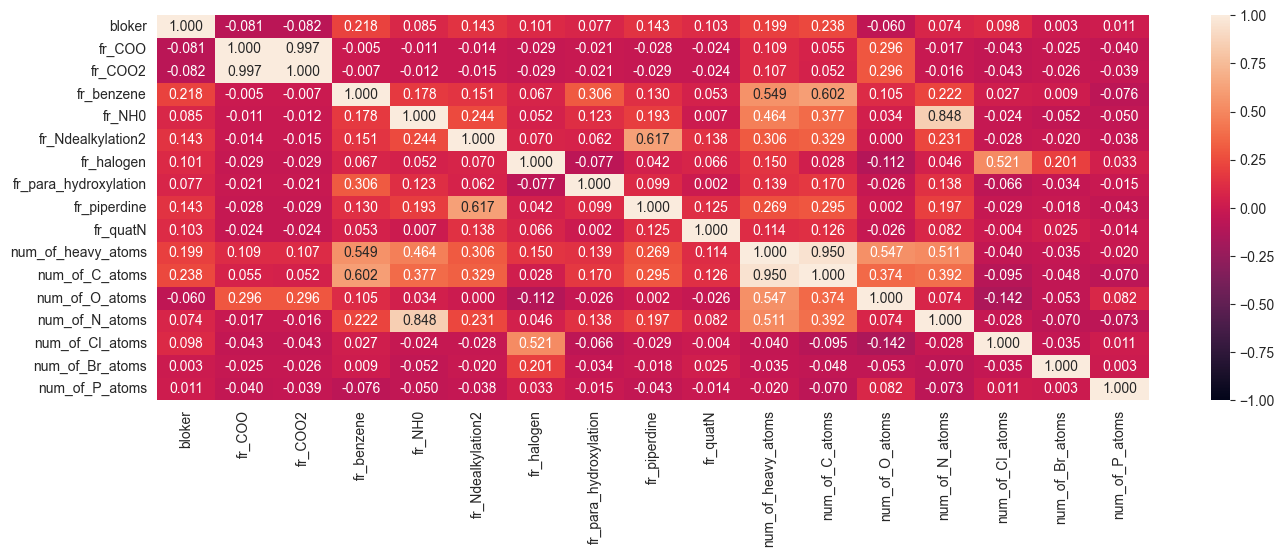

In [37]:
corr = data.corr(numeric_only=True)
plt.figure(figsize = (16,5))
sns.heatmap(corr, vmax=1, vmin=-1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt=".3f")

In [38]:
data['mol_w'] = data['molecula'].apply(lambda x: Descriptors.ExactMolWt(x))
data['num_valence_electrons'] = data['molecula'].apply(lambda x: Descriptors.NumValenceElectrons(x))
data['num_heteroatoms'] = data['molecula'].apply(lambda x: Descriptors.NumHeteroatoms(x))
data['tpsa'] = data['molecula'].apply(lambda x: Descriptors.TPSA(x))
from rdkit.Chem import Crippen
data['clogp']= data['molecula'].apply(lambda x: Crippen.MolLogP(x))
data['clogmr']= data['molecula'].apply(lambda x: Crippen.MolMR(x))



In [39]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

# model = word2vec.Word2Vec.load('model_300dim.pkl')
data['sentence'] = data.apply(lambda x: MolSentence(mol2alt_sentence(x['molecula'], 1)), axis=1)
# data['mol2vec'] = [DfVec(x) for x in sentences2vec(data['sentence'], model, unseen='UNK')]
# data['vec'] = data['mol2vec'].vec
data['sentence_len'] = data['sentence'].apply(len)
data = data.drop(['sentence', 'SMILES'], axis=1)
data.head()

,bloker,molecula,fr_COO,fr_COO2,fr_benzene,fr_NH0,fr_Ndealkylation2,fr_halogen,fr_para_hydroxylation,fr_piperdine,...,num_of_Cl_atoms,num_of_Br_atoms,num_of_P_atoms,mol_w,num_valence_electrons,num_heteroatoms,tpsa,clogp,clogmr,sentence_len
0,1,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,0,2,0,0,0,0,...,0,0,0,152.015667,50,5,57.36,1.01549,39.0734,20
1,0,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,1,4,0,6,0,0,...,0,0,0,408.125356,152,12,78.66,1.29970,81.7541,56
2,0,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,1,3,0,2,0,0,...,2,0,0,255.007851,82,7,90.71,2.00980,64.1078,32
3,0,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,3,1,0,2,0,0,...,0,0,0,409.148950,154,6,60.77,4.88830,108.8176,60
4,0,<rdkit.Chem.rdchem.Mol object at 0x000001EC156...,0,0,3,0,1,0,0,1,...,0,0,0,474.173356,174,6,71.20,4.65810,135.3748,68


In [40]:
from rdkit.Chem import AllChem
from rdkit.Chem import rdchem

# generate a conformer for each molecule
#data['molecula'] = data['molecula'].apply(lambda x: AllChem.AddHs(x))
#data['molecula'].apply(lambda x: AllChem.EmbedMolecule(x))

def get_mol_volume(x):
    try:
        return AllChem.ComputeMolVolume(x, x.GetConformer().GetId())
    except:
        return None

#data['volume'] = data['molecula'].apply(get_mol_volume)

In [41]:
#data['volume'] = data['volume'].fillna(data['volume'].median())

<Axes: >

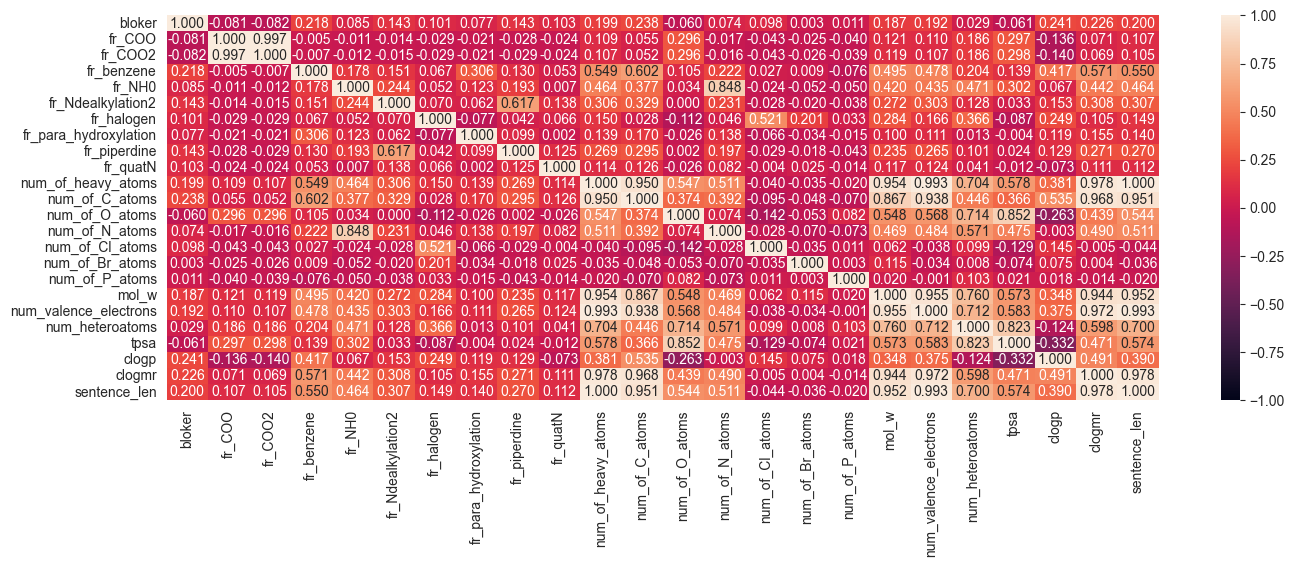

In [42]:
data = data.drop(['molecula'], axis=1)

corr = data.corr(numeric_only=True)
plt.figure(figsize = (16,5))
sns.heatmap(corr, vmax=1, vmin=-1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt=".3f")

In [43]:
data.head()

,bloker,fr_COO,fr_COO2,fr_benzene,fr_NH0,fr_Ndealkylation2,fr_halogen,fr_para_hydroxylation,fr_piperdine,fr_quatN,...,num_of_Cl_atoms,num_of_Br_atoms,num_of_P_atoms,mol_w,num_valence_electrons,num_heteroatoms,tpsa,clogp,clogmr,sentence_len
0,1,0,0,0,2,0,0,0,0,0,...,0,0,0,152.015667,50,5,57.36,1.01549,39.0734,20
1,0,0,0,1,4,0,6,0,0,1,...,0,0,0,408.125356,152,12,78.66,1.29970,81.7541,56
2,0,0,0,1,3,0,2,0,0,0,...,2,0,0,255.007851,82,7,90.71,2.00980,64.1078,32
3,0,0,0,3,1,0,2,0,0,0,...,0,0,0,409.148950,154,6,60.77,4.88830,108.8176,60
4,0,0,0,3,0,1,0,0,1,1,...,0,0,0,474.173356,174,6,71.20,4.65810,135.3748,68


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

TARGET = 'bloker'
def get_features(data, target, scaler = None):
    result = data.drop([target], axis=1)
    if scaler is not None:
        result = scaler.transform(result)
    return result


In [45]:
from sklearn.preprocessing import MinMaxScaler
def solve_classification_problem(data, target_label, model):
    target = data[target_label]
    features = get_features(data, target_label)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.30, random_state=np.random.RandomState(10))
    scaler = MinMaxScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    model.fit(features_train, target_train)

    predictions_valid = model.predict_proba(features_valid)[:, 1]
    err = roc_auc_score(target_valid, predictions_valid)
    print(f"ROC AUC модели: {err:.2f}")
    return model, scaler

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in kernels:
    model = SVC(kernel = i, probability=True)
    print(f"{i}")
    solve_classification_problem(data, TARGET, model)


linear
ROC AUC модели: 0.68
poly
ROC AUC модели: 0.69
rbf
ROC AUC модели: 0.70
sigmoid
ROC AUC модели: 0.55


In [46]:

def solve_regression_problem(data, target_label, model):
    target = data[target_label]
    features = get_features(data, target_label)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.30, random_state=np.random.RandomState(10))
    scaler = MinMaxScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    model.fit(features_train, target_train)

    predictions_valid = model.predict(features_valid)
    err = mean_squared_error(target_valid, predictions_valid, squared=False)
    print(f"RMSE модели: {err:.2f}")
    return model, scaler


In [47]:
from sklearn.tree import DecisionTreeClassifier
criterions = ["gini", "entropy"]
for i in criterions:
    model = DecisionTreeClassifier(criterion = i, random_state=np.random.RandomState(10))
    print(f"{i}")
    solve_classification_problem(data, TARGET, model)

gini
ROC AUC модели: 0.60
entropy
ROC AUC модели: 0.60


In [48]:
from sklearn.ensemble import RandomForestClassifier
criterions = ["gini", "entropy"]
for i in criterions:
    model = RandomForestClassifier(n_estimators=1000, random_state=np.random.RandomState(10), max_depth=None, min_samples_split=2)
    print(f"{i}")
    solve_classification_problem(data, TARGET, model)

gini
ROC AUC модели: 0.73
entropy
ROC AUC модели: 0.73


In [49]:
from sklearn.linear_model import LogisticRegression
solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
for i in solvers:
    model = LogisticRegression(solver = i, random_state=np.random.RandomState(10))
    print(f"{i}")
    solve_classification_problem(data, TARGET, model)

liblinear
ROC AUC модели: 0.71
newton-cg
ROC AUC модели: 0.71
lbfgs
ROC AUC модели: 0.71
sag
ROC AUC модели: 0.71
saga
ROC AUC модели: 0.71


In [50]:
from sklearn.ensemble import GradientBoostingClassifier
losses = ['deviance', 'exponential']
for i in losses:
    model = GradientBoostingClassifier(loss = i, random_state=np.random.RandomState(10))
    print(f"{i}")
    solve_classification_problem(data, TARGET, model)

deviance
ROC AUC модели: 0.74
exponential
ROC AUC модели: 0.74


In [51]:
from sklearn.ensemble import GradientBoostingRegressor
losses = ['huber', 'quantile']
for i in losses:
    model = GradientBoostingRegressor(loss = i, random_state=np.random.RandomState(10))
    print(f"{i}")
    solve_regression_problem(data, TARGET, model)

huber
RMSE модели: 0.41
quantile
RMSE модели: 0.85


In [52]:
from sklearn.ensemble import VotingClassifier
votings = ['hard', 'soft']
clf1 = LogisticRegression(multi_class='multinomial', random_state=np.random.RandomState(10))
clf2 = RandomForestClassifier(n_estimators=50, random_state=np.random.RandomState(10))
clf3 = GradientBoostingClassifier(random_state=np.random.RandomState(10))
clf4 = DecisionTreeClassifier(random_state=np.random.RandomState(10))
model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gb', clf3), ('dt', clf4)], voting = votings[1])
solve_classification_problem(data, TARGET, model)

ROC AUC модели: 0.72


(VotingClassifier(estimators=[('lr',
                               LogisticRegression(multi_class='multinomial',
                                                  random_state=RandomState(MT19937) at 0x1EC256DCE40)),
                              ('rf',
                               RandomForestClassifier(n_estimators=50,
                                                      random_state=RandomState(MT19937) at 0x1EC256DCD40)),
                              ('gb',
                               GradientBoostingClassifier(random_state=RandomState(MT19937) at 0x1EC256DC440)),
                              ('dt',
                               DecisionTreeClassifier(random_state=RandomState(MT19937) at 0x1EC2577E040))],
                  voting='soft'),
 MinMaxScaler())

In [53]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 70)
solve_classification_problem(data, TARGET, model)

ROC AUC модели: 0.73


(KNeighborsClassifier(n_neighbors=70), MinMaxScaler())

In [54]:
from sklearn.dummy import DummyClassifier
model = DummyClassifier()
solve_classification_problem(data, TARGET, model)

ROC AUC модели: 0.50


(DummyClassifier(), MinMaxScaler())

In [55]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
solve_classification_problem(data, TARGET, model)

ROC AUC модели: 0.69


(GaussianNB(), MinMaxScaler())

In [56]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
solve_classification_problem(data, TARGET, model)

ROC AUC модели: 0.68


(MultinomialNB(), MinMaxScaler())

In [57]:
from sklearn.naive_bayes import ComplementNB
model = ComplementNB()
solve_classification_problem(data, TARGET, model)

ROC AUC модели: 0.68


(ComplementNB(), MinMaxScaler())

In [58]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
solve_classification_problem(data, TARGET, model)

ROC AUC модели: 0.67


(BernoulliNB(), MinMaxScaler())

In [59]:
from sklearn.naive_bayes import CategoricalNB
model = CategoricalNB()
solve_classification_problem(data, TARGET, model)

ROC AUC модели: 0.50


(CategoricalNB(), MinMaxScaler())

In [50]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
solve_classification_problem(data, TARGET, model)

ROC AUC модели: 0.73


(MultinomialNB(), MinMaxScaler())

In [51]:
from sklearn.naive_bayes import ComplementNB
model = ComplementNB()
solve_classification_problem(data, TARGET, model)

ROC AUC модели: 0.73


(ComplementNB(), MinMaxScaler())

In [52]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
solve_classification_problem(data, TARGET, model)

ROC AUC модели: 0.74


(BernoulliNB(), MinMaxScaler())

In [53]:
from sklearn.naive_bayes import CategoricalNB
model = CategoricalNB()
solve_classification_problem(data, TARGET, model)

ROC AUC модели: 0.50


(CategoricalNB(), MinMaxScaler())